In [5]:
#!pip install torch torchaudio scikit-learn numpy
#!pip install soundfile

# IMPORT

In [6]:
import os
from collections import Counter

import torch
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt

from src.preprocessing.dataset import (
    list_ravdess_files,
    filter_audio_speech,
    RavdessDataset,
    extract_label_idx,
    IDX2LABEL,
)
from src.models.crnn import CRNN
from src.utils import set_seed, evaluate

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report



In [ ]:

set_seed(42)

DATA_ROOT = "./data"
EPOCHS = 50
BATCH_SIZE = 64
LR = 1e-3
WEIGHT_DECAY = 1e-4

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", device)

# 1) lista file
all_files = list_ravdess_files(DATA_ROOT)
all_files = filter_audio_speech(all_files)
if len(all_files) == 0:
    raise RuntimeError("Nessun file trovato. Controlla DATA_ROOT e filter_audio_speech().")

# 2) labels per stratify
labels = [extract_label_idx(fp) for fp in all_files]
print("Tot files:", len(all_files))
print("Distribuzione classi:", Counter(labels))

# 3) split random stratificato (Phase 1: NON speaker-independent)
train_files, temp_files, train_y, temp_y = train_test_split(
    all_files, labels, test_size=0.30, random_state=42, stratify=labels
)
val_files, test_files, _, _ = train_test_split(
    temp_files, temp_y, test_size=0.50, random_state=42, stratify=temp_y
)

print(f"Split -> train {len(train_files)} | val {len(val_files)} | test {len(test_files)}")

# 4) dataset + loader
train_ds = RavdessDataset(train_files)
val_ds   = RavdessDataset(val_files)
test_ds  = RavdessDataset(test_files)

# num_workers=0: più stabile su Windows/CPU (evita crash dei processi worker)
# pin_memory=False: utile solo con GPU (CUDA), su CPU non porta vantaggi
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=0, pin_memory=False)
val_loader   = DataLoader(val_ds,   batch_size=BATCH_SIZE, shuffle=False, num_workers=0, pin_memory=False)
test_loader  = DataLoader(test_ds,  batch_size=BATCH_SIZE, shuffle=False, num_workers=0, pin_memory=False)

# 5) model
model = CRNN(n_classes=8, n_mels=64).to(device)

optimizer = torch.optim.AdamW(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode="max", factor=0.5, patience=6)

best_val_acc = 0.0
best_path = "best_phase1.pt"

# --- HISTORY PER GRAFICO ---
val_acc_hist = []
test_acc_hist = []


Device: cpu
Tot files: 1440
Distribuzione classi: Counter({1: 192, 2: 192, 3: 192, 4: 192, 5: 192, 6: 192, 7: 192, 0: 96})
Split -> train 1008 | val 216 | test 216


In [8]:

# 6) training loop
for epoch in range(1, EPOCHS + 1):
    model.train()
    running_loss = 0.0
    running_correct = 0
    total = 0

    for x, y in train_loader:
        x = x.to(device)
        y = y.to(device)

        optimizer.zero_grad()
        logits = model(x)
        loss = torch.nn.functional.cross_entropy(logits, y)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 5.0)
        optimizer.step()

        running_loss += loss.item() * y.size(0)
        running_correct += (logits.argmax(dim=1) == y).sum().item()
        total += y.size(0)

    train_loss = running_loss / total
    train_acc = running_correct / total

    val_loss, val_acc = evaluate(model, val_loader, device)
    test_loss_epoch, test_acc_epoch = evaluate(model, test_loader, device)  # <-- test ogni epoca

    scheduler.step(val_acc)

    # salva history
    val_acc_hist.append(val_acc)
    test_acc_hist.append(test_acc_epoch)

    print(
        f"Epoch {epoch}/{EPOCHS} | "
        f"train loss {train_loss:.4f} acc {train_acc:.4f} | "
        f"val loss {val_loss:.4f} acc {val_acc:.4f} | "
        f"test acc {test_acc_epoch:.4f}"
    )

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), best_path)

Epoch 1/50 | train loss 2.0501 acc 0.1508 | val loss 2.0313 acc 0.2083 | test acc 0.1991
Epoch 2/50 | train loss 1.9310 acc 0.2609 | val loss 1.8825 acc 0.2778 | test acc 0.2731
Epoch 3/50 | train loss 1.7819 acc 0.3214 | val loss 1.7485 acc 0.3194 | test acc 0.3194
Epoch 4/50 | train loss 1.6542 acc 0.3591 | val loss 1.6715 acc 0.3657 | test acc 0.3472
Epoch 5/50 | train loss 1.5311 acc 0.4256 | val loss 1.5346 acc 0.4120 | test acc 0.4074
Epoch 6/50 | train loss 1.4854 acc 0.4355 | val loss 1.5281 acc 0.4213 | test acc 0.4167
Epoch 7/50 | train loss 1.4366 acc 0.4732 | val loss 1.4665 acc 0.4213 | test acc 0.3889
Epoch 8/50 | train loss 1.3295 acc 0.5159 | val loss 1.4026 acc 0.4537 | test acc 0.4907
Epoch 9/50 | train loss 1.2665 acc 0.5337 | val loss 1.3581 acc 0.4907 | test acc 0.4398
Epoch 10/50 | train loss 1.1702 acc 0.5823 | val loss 1.4786 acc 0.4167 | test acc 0.4954
Epoch 11/50 | train loss 1.1862 acc 0.5734 | val loss 1.4082 acc 0.4352 | test acc 0.3981
Epoch 12/50 | train

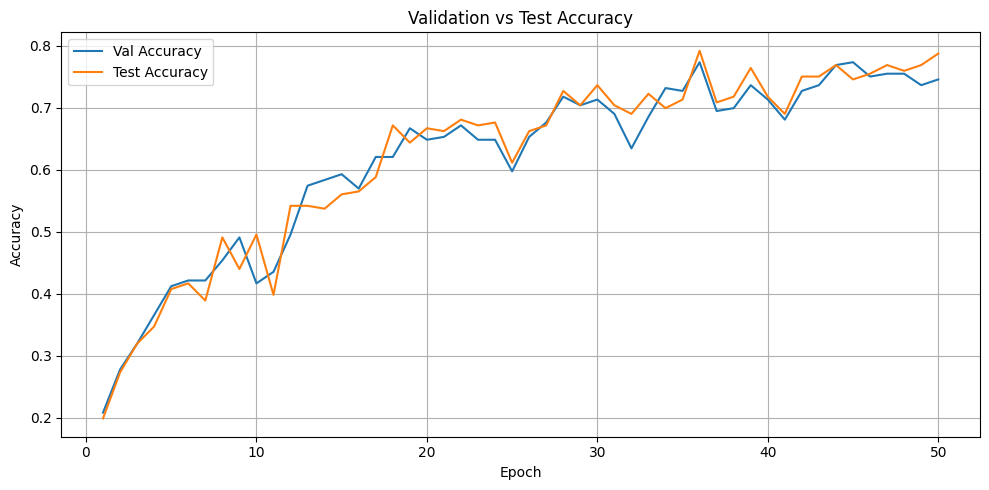


Best val acc: 0.7731481481481481
TEST (best checkpoint) | loss 0.8168 acc 0.7917

Classification report:
              precision    recall  f1-score   support

     neutral     0.6471    0.7857    0.7097        14
        calm     0.8571    0.8571    0.8571        28
       happy     0.9000    0.6207    0.7347        29
         sad     0.6486    0.8276    0.7273        29
       angry     0.8889    0.8276    0.8571        29
     fearful     0.6857    0.8276    0.7500        29
     disgust     0.8519    0.7931    0.8214        29
   surprised     0.9200    0.7931    0.8519        29

    accuracy                         0.7917       216
   macro avg     0.7999    0.7916    0.7887       216
weighted avg     0.8103    0.7917    0.7938       216

Confusion matrix:
[[11  2  0  1  0  0  0  0]
 [ 2 24  0  2  0  0  0  0]
 [ 2  0 18  2  2  4  0  1]
 [ 1  1  0 24  0  3  0  0]
 [ 0  1  0  1 24  1  2  0]
 [ 0  0  1  3  0 24  0  1]
 [ 1  0  0  3  1  1 23  0]
 [ 0  0  1  1  0  2  2 23]]


In [9]:

# --- GRAFICO VAL vs TEST ---
epochs_range = range(1, EPOCHS + 1)

plt.figure(figsize=(10, 5))
plt.plot(epochs_range, val_acc_hist, label="Val Accuracy")
plt.plot(epochs_range, test_acc_hist, label="Test Accuracy")
plt.title("Validation vs Test Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# 7) test finale con best checkpoint
print("\nBest val acc:", best_val_acc)
model.load_state_dict(torch.load(best_path, map_location=device))

test_loss, test_acc = evaluate(model, test_loader, device)
print(f"TEST (best checkpoint) | loss {test_loss:.4f} acc {test_acc:.4f}")

# 8) report dettagliato
y_true = []
y_pred = []
model.eval()
with torch.no_grad():
    for x, y in test_loader:
        x = x.to(device)
        logits = model(x).cpu()
        preds = logits.argmax(dim=1).numpy().tolist()
        y_pred.extend(preds)
        y_true.extend(y.numpy().tolist())

print("\nClassification report:")
target_names = [IDX2LABEL[i] for i in range(8)]
print(classification_report(y_true, y_pred, target_names=target_names, digits=4))

print("Confusion matrix:")
print(confusion_matrix(y_true, y_pred))
